# Simulazione Real Environment MDP

## Drive & Environment Setting

In [1]:
IN_COLAB = False

try:
  import google.colab
  IN_COLAB = True
except:
  pass

if IN_COLAB == True:
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/Tesi_GDrive
  PROJECT_PATH = '/content/gdrive/MyDrive/Tesi_GDrive'
  #!ls
else:
  %cd /Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
  PROJECT_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os

if IN_COLAB == True:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))
else:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.activations import exponential, relu
from keras import backend as K
import tensorflow as tf
#from tensorflow.keras.layers import Input, Layer, InputSpec, Reshape
#from tensorflow.keras import initializers
#from tensorflow.keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
from scipy.optimize import minimize, differential_evolution

from pkl import store_data, load_data
#from functions.compressor import compress
from functions.compressor_param import compress_2
from functions.mapping import ind2sub, sub2ind3d

import random
from collections import defaultdict

import time

print("Libraries imported")

/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive


2023-05-22 23:06:53.420594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported


## Import Anagrafica & CTA

In [2]:
cta30_def_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_def.csv')
CTA30_def = [cta30_def_path]
  
df_def = pd.read_csv(CTA30_def[0])

#cta30_18_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2018.csv')
#cta30_19_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2019.csv')
#cta30_20_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2020.csv')
#cta30_21_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2021.csv')
#cta30_22_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2022.csv')
#CTA30_18 = [cta30_18_path]
#CTA30_19 = [cta30_19_path]
#CTA30_20 = [cta30_20_path]
#CTA30_21 = [cta30_21_path]
#CTA30_22 = [cta30_22_path]

#df18= pd.read_csv(CTA30_18[0])
#df19= pd.read_csv(CTA30_19[0])
#df20= pd.read_csv(CTA30_20[0])
#df21= pd.read_csv(CTA30_21[0])
#df22= pd.read_csv(CTA30_22[0])
#df = pd.concat([df18, df19, df20, df21, df22], ignore_index=True)

cta30_partitioned = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/df_partitioned.csv')
CTA30_partitioned = [cta30_partitioned]
df = pd.read_csv(CTA30_partitioned[0])
df_standard = df.drop(['Cluster','a1_discrete','a2_discrete','a3_discrete'], axis=1)

#df['VLV_RAF_REG_00'] = df['VLV_RAF_REG_00'] / 100
#df['VLV_SUR_REG_00'] = df['VLV_SUR_REG_00'] / 100

scaler = MinMaxScaler()
act_f_m = df.loc[:,'F_M_FDBK_00']
a_f_m_reshaped = np.array(act_f_m).reshape(-1, 1)
a_f_m_scaled = scaler.fit_transform(a_f_m_reshaped)

min_f = np.min(a_f_m_scaled)
max_f = np.max(a_f_m_scaled)

a_raf_df = df['VLV_RAF_REG_00'] * 0.5
a_sur_df = df['VLV_SUR_REG_00'] * 0.5 + 0.5

a_df = pd.concat([a_raf_df, a_sur_df], ignore_index=True)

#cta_pca = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/pca_df_clustered_partitioned.csv')
#CTA_pca = [cta_pca]
pca_df = compress_2(df_standard, 0.93)

[r,c] = df.shape
print("df shape: ", df.shape)
[r,n_components] = pca_df.shape
print("pca_df shape: ", pca_df.shape)



df shape:  (2176378, 80)
pca_df shape:  (2176378, 9)


<Axes: >

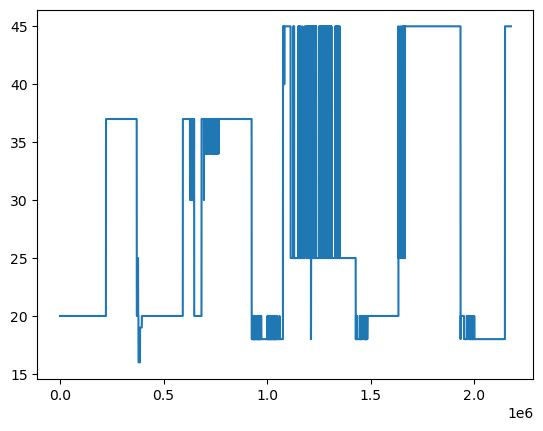

In [40]:
df['T_M_SP_00'].plot()
#df['F_M_FDBK_00'].plot()

<Axes: >

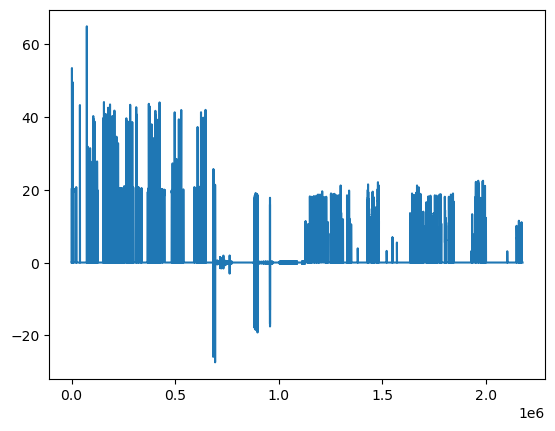

In [43]:
df['PW_ATT_M_00'].plot()

## Clustering & MDP Preparation

### Discretizzazione azioni

In [3]:
# Trova il valore più vicino dal basso per ogni azione
def valore_piu_vicino(lista, x):
    if x <= lista[0]:
        return lista[0]
    if x >= lista[-1]:
        return lista[-1]
    
    left = 0
    right = len(lista) - 1
    
    while left <= right:
        mid = (left + right) // 2
        
        if lista[mid] == x:
            return lista[mid]
        elif lista[mid] < x:
            left = mid + 1
        else:
            right = mid - 1
    
    if abs(lista[left] - x) < abs(lista[right] - x):
        return lista[left]
    else:
        return lista[right]

# Aggiungi un ultimo step agli intervalli di discretizzazione, così da considerare il valore massimo
def discretize_actions(min_value, max_value, num, upper):
    ret = np.linspace(min_value, max_value, num=num)
    if upper == True:
        step = ret[1] - ret[0]
        # add to last element step + ret[-1]
        ret = np.append(ret, step + ret[-1])
    return ret

In [4]:
#df['a1_discrete'] = None
#df['a2_discrete'] = None
#df['a3_discrete'] = None

[S, features] = df.shape

n_a1 = 15
n_a2 = 9
n_a3 = 9

a1_intervals = discretize_actions(df['F_M_FDBK_00'].min(), df['F_M_FDBK_00'].max(), num=n_a1, upper=True)
a2_intervals = discretize_actions(0, 1, num=n_a2, upper=True)
a3_intervals = discretize_actions(0, 1, num=n_a3, upper=True)
a1_intervals_list = a1_intervals.tolist()
a2_intervals_list = a2_intervals.tolist()
a3_intervals_list = a3_intervals.tolist()

a1_intervals = [round(num, 4) for num in a1_intervals_list]
a2_intervals = [round(num, 4) for num in a2_intervals_list]
a3_intervals = [round(num, 4) for num in a3_intervals_list]



In [91]:
for i in range(S):
    ret1 = valore_piu_vicino(a1_intervals, df.loc[i,'F_M_FDBK_00'])
    df.loc[i,'a1_discrete'] = ret1

    ret2 = valore_piu_vicino(a2_intervals, df.loc[i,'VLV_RAF_REG_00'])
    df.loc[i,'a2_discrete'] = ret2

    ret3 = valore_piu_vicino(a3_intervals, df.loc[i,'VLV_SUR_REG_00'])
    df.loc[i,'a3_discrete'] = ret3


#### Graphical Model - Action

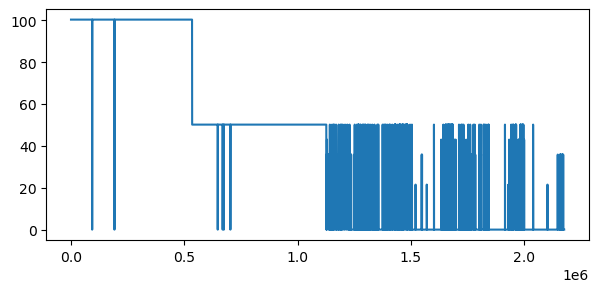

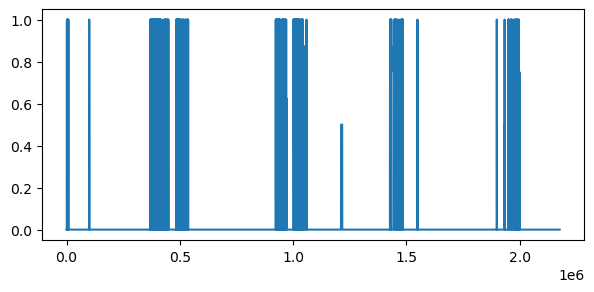

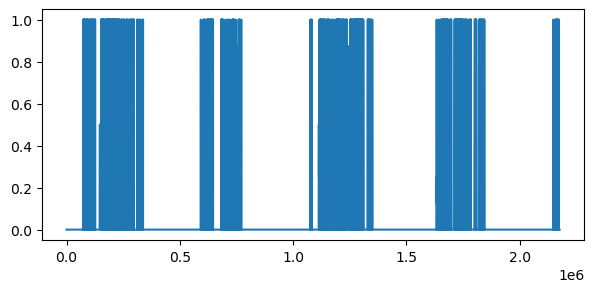

In [92]:
# plot values of a bin graphic of a1_discrete
plt.figure(figsize=(7,3))
plt.plot(df['a1_discrete'])
plt.show()

# plot values of a bin graphic of a2_discrete
plt.figure(figsize=(7,3))
plt.plot(df['a2_discrete'])
plt.show()

# plot values of a bin graphic of a3_discrete
plt.figure(figsize=(7,3))
plt.plot(df['a3_discrete'])
plt.show()


#### Actions Array (ind2sub)

In [5]:
n_a1 = len(a1_intervals)
n_a2 = len(a2_intervals)
n_a3 = len(a3_intervals)

print("n_a1:", n_a1)
print("n_a2:", n_a2)
print("n_a3:", n_a3)

n_A = n_a1*n_a2*n_a3
print("numero azioni: ", n_A)

actions = np.zeros((n_A, 3))
for i in range (n_A):
    [a1, a2, a3] = ind2sub((n_a1, n_a2, n_a3), i)
    actions[i,0] = a1_intervals[a1]
    actions[i,1] = a2_intervals[a2]
    actions[i,2] = a3_intervals[a3]

print("actions: ",actions)
print("actions shape: ",actions.shape)

n_a1: 16
n_a2: 10
n_a3: 10
numero azioni:  1600
actions:  [[  0.       0.       0.    ]
 [  0.       0.       0.125 ]
 [  0.       0.       0.25  ]
 ...
 [107.5063   1.125    0.875 ]
 [107.5063   1.125    1.    ]
 [107.5063   1.125    1.125 ]]
actions shape:  (1600, 3)


#### Save (no Cluster)

In [95]:
# save new df on cvs as df_clustered_partitioned.csv
df['Cluster'] = None
#df.to_csv(os.path.join(PROJECT_PATH, 'CTA30/DF_clean/df_partitioned.csv'), index=False)
# save pca_df on cvs as pca_df_clustered_partitioned.csv
#pca_df.to_csv(os.path.join(PROJECT_PATH, 'CTA30/DF_clean/pca_df_clustered_partitioned.csv'), index=False)

#save actions as array
np.save(os.path.join(PROJECT_PATH, 'MDP_data/actions.npy'), actions)

In [6]:
#load df_partitioned.csv
df_partitioned_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/df_partitioned.csv')
df_partitioned = [df_partitioned_path]
df_partitioned = pd.read_csv(df_partitioned[0])
#load cluster_group_df.csv
cluster_group_df_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/cluster_group_df.csv')
cluster_group_df = [cluster_group_df_path]
cluster_group_df = pd.read_csv(cluster_group_df[0])


#### Pie Rapresentation

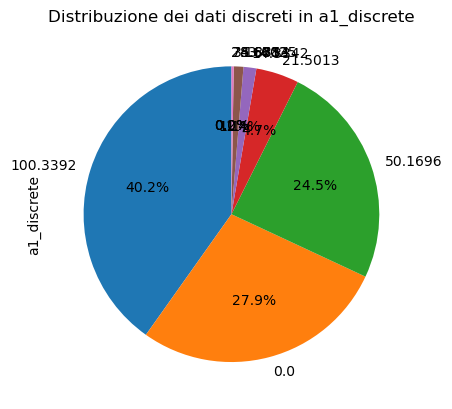

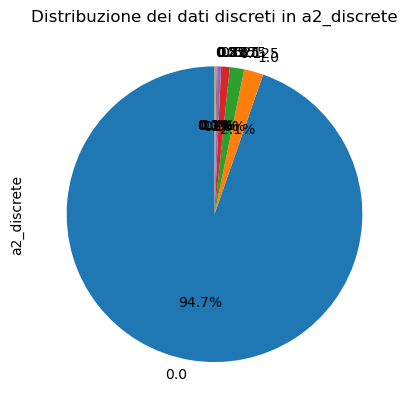

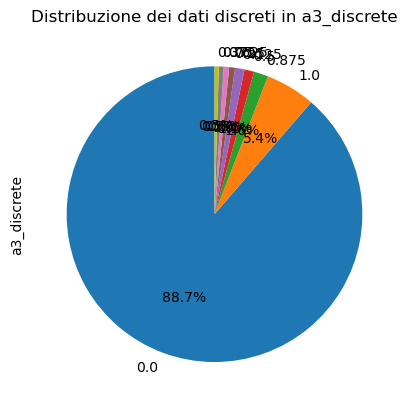

In [10]:
# Dati per il grafico a torta
labels = df['a1_discrete'].unique()
sizes = df['a1_discrete'].value_counts()

# Crea il grafico a torta
ax = sizes.plot.pie(labels=labels, autopct='%1.1f%%', startangle=90)

# Aggiunge un titolo al grafico
ax.set_title("Distribuzione dei dati discreti in a1_discrete")

# Mostra il grafico
plt.show()

# Dati per il grafico a torta
labels = df['a2_discrete'].unique()
sizes = df['a2_discrete'].value_counts()

# Crea il grafico a torta
ax = sizes.plot.pie(labels=labels, autopct='%1.1f%%', startangle=90)

# Aggiunge un titolo al grafico
ax.set_title("Distribuzione dei dati discreti in a2_discrete")

# Mostra il grafico
plt.show()

# Dati per il grafico a torta
labels = df['a3_discrete'].unique()
sizes = df['a3_discrete'].value_counts()

# Crea il grafico a torta
ax = sizes.plot.pie(labels=labels, autopct='%1.1f%%', startangle=90)

# Aggiunge un titolo al grafico
ax.set_title("Distribuzione dei dati discreti in a3_discrete")

# Mostra il grafico
plt.show()


### Clustering

In [103]:
campioni = [8, 10, 15, 22, 30]
cluster_group = []
for i in campioni:
    n_cluster = i
    kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(pca_df)
    cluster_group.append(kmeans.labels_)

cluster_group_df = pd.DataFrame(cluster_group)
cluster_group_df = cluster_group_df.transpose()
cluster_group_df.shape
cluster_group_df.columns = ['Cluster_8', 'Cluster_10', 'Cluster_15', 'Cluster_22', 'Cluster_30']
cluster_group_df.to_csv(os.path.join(PROJECT_PATH, 'CTA30/DF_clean/cluster_group_df.csv'), index=False)



#### Grapich Distribution - Clusters

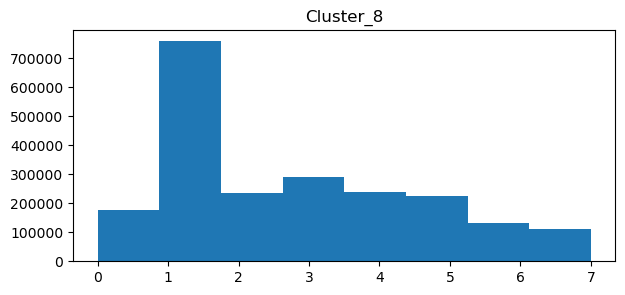

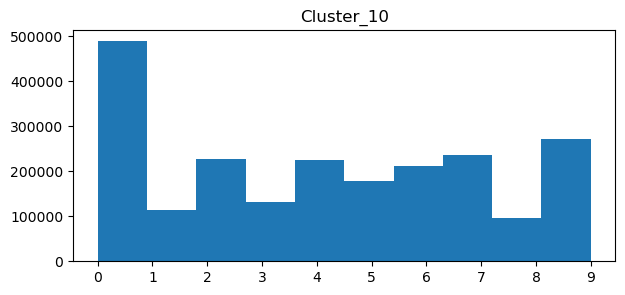

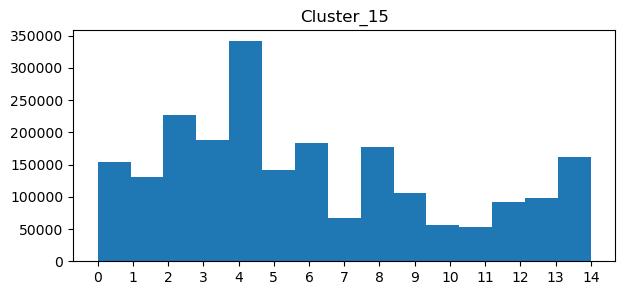

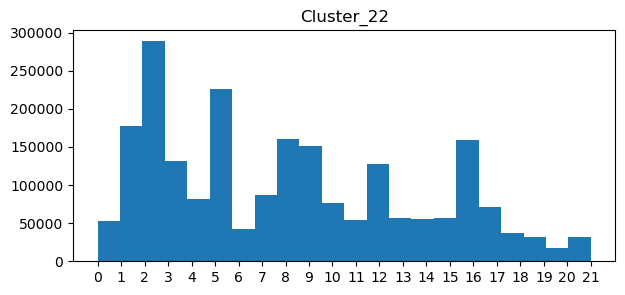

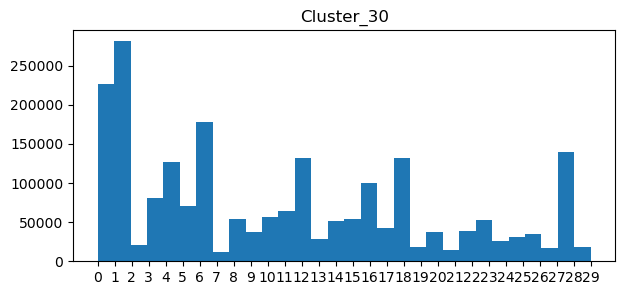

In [11]:
frequenze = cluster_group_df['Cluster_8'].value_counts().values
etichette = cluster_group_df['Cluster_8'].value_counts().index

plt.figure(figsize=(7,3))
plt.hist(etichette, bins=8, weights=frequenze)
plt.xticks(etichette)
plt.title("Cluster_8")
plt.show()

frequenze = cluster_group_df['Cluster_10'].value_counts().values
etichette = cluster_group_df['Cluster_10'].value_counts().index

plt.figure(figsize=(7,3))
plt.hist(etichette, bins=10, weights=frequenze)
plt.xticks(etichette)
plt.title("Cluster_10")
plt.show()

frequenze = cluster_group_df['Cluster_15'].value_counts().values
etichette = cluster_group_df['Cluster_15'].value_counts().index

plt.figure(figsize=(7,3))
plt.hist(etichette, bins=15, weights=frequenze)
plt.xticks(etichette)
plt.title("Cluster_15")
plt.show()

frequenze = cluster_group_df['Cluster_22'].value_counts().values
etichette = cluster_group_df['Cluster_22'].value_counts().index

plt.figure(figsize=(7,3))
plt.hist(etichette, bins=22, weights=frequenze)
plt.xticks(etichette)
plt.title("Cluster_22")
plt.show()

frequenze = cluster_group_df['Cluster_30'].value_counts().values
etichette = cluster_group_df['Cluster_30'].value_counts().index

plt.figure(figsize=(7,3))
plt.hist(etichette, bins=30, weights=frequenze)
plt.xticks(etichette)
plt.title("Cluster_30")
plt.show()


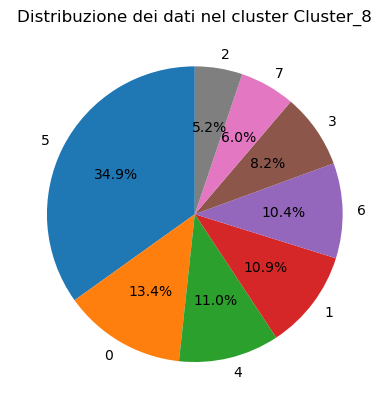

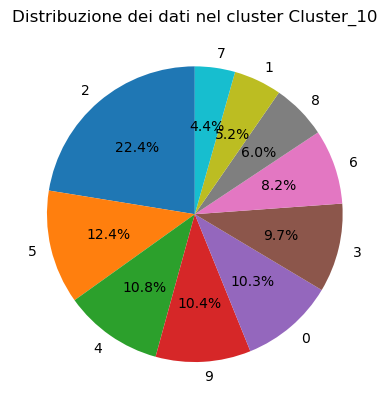

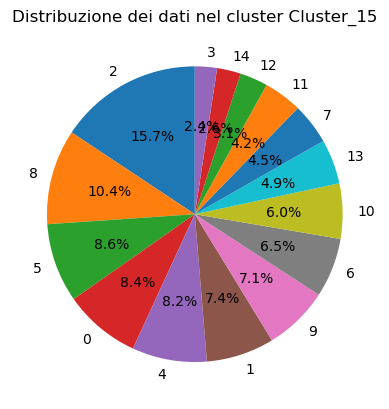

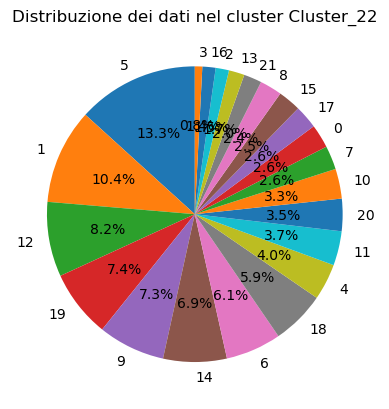

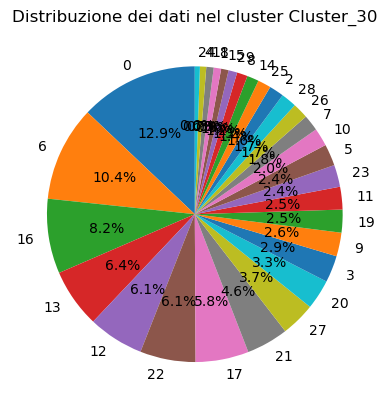

In [19]:
# Cicla su ogni colonna del dataframe
for cluster in cluster_group_df.columns:
    # Dati per il grafico a torta
    labels = cluster_group_df[cluster].unique()
    sizes = cluster_group_df[cluster].value_counts()

    # Crea il grafico a torta
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

    # Aggiunge un titolo al grafico
    ax.set_title("Distribuzione dei dati nel cluster {}".format(cluster))

    # Mostra il grafico
    plt.show()

#### Matrice di Transizione

In [8]:
# load cluster_group_df.csv and df_partitioned.csv from CTA30/DF_clean
cluster_group_df_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/cluster_group_df.csv')
cluster_group_df = [cluster_group_df_path]
cluster_group_df = pd.read_csv(cluster_group_df[0])

df_partitioned_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/df_partitioned.csv')
df_partitioned = [df_partitioned_path]
df_partitioned = pd.read_csv(df_partitioned[0])

# load actions.npy
actions_path = os.path.join(PROJECT_PATH, 'MDP_data/actions.npy')
actions = [actions_path]
actions = np.load(actions[0])



ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [10]:
def sub2ind3d_(array_shape, coords):
   
    if len(array_shape) != len(coords):
        raise ValueError("La lunghezza di array_shape e coords devono essere uguali")

    if any(coord < 0 or coord >= shape for coord, shape in zip(coords, array_shape)):
        raise ValueError("Coordinate non valide per l'array")

    index = 0
    for i, coord in enumerate(coords):
        index += coord * np.prod(array_shape[i + 1:])
    return index

In [6]:
S = df.shape[0]
s_cluster = S
n_A = actions.shape[0]
print("n_A: ", n_A)

n_A:  1600


In [11]:
## NUOVO TENTATIVO
#temporal_group = ['Cluster_8']
for cluster in cluster_group_df.columns:

    df['Cluster'] = cluster_group_df[cluster]
    n_cluster = cluster_group_df[cluster].max() + 1
    T = np.zeros((n_cluster, n_cluster, n_A))

    for s in range(S):

        s_cluster = df.loc[s, 'Cluster']
        if s != S-1:
            s_prime = s + 1
        else:
            break
        
        
        s_cluster_prime = df.loc[s_prime-1, 'Cluster']
        
        a_dis = [df.loc[s, 'a1_discrete'], df.loc[s, 'a2_discrete'], df.loc[s, 'a3_discrete']]
        a1_index = a1_intervals.index(a_dis[0])
        a2_index = a2_intervals.index(a_dis[1])
        a3_index = a3_intervals.index(a_dis[2])
        a_coord = [a1_index, a2_index, a3_index]
        a = sub2ind3d_((n_a1, n_a2, n_a3), a_coord)
        T[int(s_cluster), int(df.loc[s_prime, 'Cluster']), int(a)] += 1


    for a in range(len(actions)):
        sum_a = T[:, :, a].sum(axis=1)
        T[:, :, a] = T[:, :, a] / np.maximum(sum_a, 1e-6)[:, np.newaxis]#T[:, :, a].sum(axis=1)[:, np.newaxis]
        if np.isnan(T).any() == True:
            print("T contiene dei nan")

    #check if there is a nan in T
    print("T sum: ", T.sum())
    print("T nan: ", np.isnan(T).any())
    print("T inf: ", np.isinf(T).any())
    print("T max: ", np.max(T))


    # Specifica il nome della directory cluster_model
    cluster_model = cluster

    # Crea il percorso completo per la directory cluster_model
    cluster_model_directory = os.path.join(PROJECT_PATH, 'MDP_data', cluster_model)

    # Crea la directory cluster_model se non esiste
    if not os.path.exists(cluster_model_directory):
        os.makedirs(cluster_model_directory)
        print("Directory", cluster_model, "creata con successo!")

    # Salvataggio dell'array T nella directory cluster_model
    T_file_path = os.path.join(cluster_model_directory, 'T_' + cluster_model + '.npy')
    np.save(T_file_path, T)
    



T sum:  349.0
T nan:  False
T inf:  False
T max:  1.0
T sum:  367.0
T nan:  False
T inf:  False
T max:  1.0
T sum:  396.0
T nan:  False
T inf:  False
T max:  1.0
T sum:  471.9999999999999
T nan:  False
T inf:  False
T max:  1.0
T sum:  488.99999999999983
T nan:  False
T inf:  False
T max:  1.0


In [19]:
ind2sub((n_a1, n_a2, n_a3), 1134)

(14, 0, 0)

In [29]:
T_cluster_8 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_8/T_Cluster_8.npy'))


# Calcolo delle probabilità normalizzate
# Verifica la somma delle probabilità di transizione per ogni stato
T_cluster_8.shape

#check how many values are nan in T_cluster_8
print("not nan:", 7*8*1600- np.isnan(T_cluster_8).sum())
print(7*8*1600)

not nan: 2728
89600


In [33]:
T_cluster_30 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_30/T_Cluster_30.npy'))

print("not nan: ", 30*31*1600- np.isnan(T_cluster_30).sum())
print("nan: ", np.isnan(T_cluster_30).sum())
print("total values: ",30*31*1600)

not nan:  110430
nan:  1377570
total values:  1488000


#### Matrice dei Reward

In [ ]:
for cluster in cluster_group_df.columns:

    df['Cluster'] = cluster_group_df[cluster]
    n_cluster = cluster_group_df[cluster].max() + 1

    mean_reward = np.zeros(n_cluster)
    for i in range(n_cluster):
        cluster_values = df.loc[df['Cluster'] == i, 'PW_ATT_M_00']
        mean_reward[i] = cluster_values.mean()
    
     # save R as array on npy file calling R + cluster name
    cluster_model = cluster

    # Crea il percorso completo per la directory cluster_model
    cluster_model_directory = os.path.join(PROJECT_PATH, 'MDP_data', cluster_model)

    # Crea la directory cluster_model se non esiste
    if not os.path.exists(cluster_model_directory):
        os.makedirs(cluster_model_directory)
        print("Directory", cluster_model, "creata con successo!")

    # Salvataggio dell'array T nella directory cluster_model
    mr_file_path = os.path.join(cluster_model_directory, 'mr_' + cluster_model + '.npy')
    np.save(mr_file_path, mean_reward)





In [41]:
for cluster in cluster_group_df.columns:

    n_cluster = cluster_group_df[cluster].max() + 1
    R = np.zeros((n_cluster, len(actions)))
    mr = np.load(os.path.join(PROJECT_PATH, 'MDP_data', cluster, 'mr_' + cluster + '.npy'))

    for i in range(n_cluster):
        for j in range(len(actions)):

            R[i,j] = -mr[i]

    # save R as array on npy file calling R + cluster name
    cluster_model = cluster

    # Crea il percorso completo per la directory cluster_model
    cluster_model_directory = os.path.join(PROJECT_PATH, 'MDP_data', cluster_model)

    # Crea la directory cluster_model se non esiste
    if not os.path.exists(cluster_model_directory):
        os.makedirs(cluster_model_directory)
        print("Directory", cluster_model, "creata con successo!")

    # Salvataggio dell'array T nella directory cluster_model
    R_file_path = os.path.join(cluster_model_directory, 'R_' + cluster_model + '.npy')
    np.save(R_file_path, R)
    

In [42]:
#load every R 
R_cluster_8 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_8/R_Cluster_8.npy'))
R_cluster_10 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_10/R_Cluster_10.npy'))
R_cluster_15 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_15/R_Cluster_15.npy'))
R_cluster_22 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_22/R_Cluster_22.npy'))
R_cluster_30 = np.load(os.path.join(PROJECT_PATH, 'MDP_data/Cluster_30/R_Cluster_30.npy'))

#print the shape of every R
print("R_cluster_8 shape: ", R_cluster_8.shape)
print("R_cluster_10 shape: ", R_cluster_10.shape)
print("R_cluster_15 shape: ", R_cluster_15.shape)
print("R_cluster_22 shape: ", R_cluster_22.shape)
print("R_cluster_30 shape: ", R_cluster_30.shape)

R_cluster_8 shape:  (8, 1600)
R_cluster_10 shape:  (10, 1600)
R_cluster_15 shape:  (15, 1600)
R_cluster_22 shape:  (22, 1600)
R_cluster_30 shape:  (30, 1600)
